In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
from torchvision.models import resnet18
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set all random seeds for reproducibility
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Training data augmentation 
#    - Converts grayscale → 3-channel (ResNet expects RGB)
#    - Resizes to 256×256 (matches training resolution)
#    - Adds realistic augmentations: flip, rotation, blur, jitter
#    - Normalizes using ImageNet stats (required for pretrained ResNet)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # Convert 1-channel → 3-channel for ResNet
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Validation & Test transforms
#    - No augmentation (only resize + normalize)
test_val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load dataset folders using ImageFolder
train_data = datasets.ImageFolder(
    "synapse_patches_256/train",
    transform=train_transform
)

val_data = datasets.ImageFolder(
    "synapse_patches_256/val",
    transform=test_val_transform
)

test_data = datasets.ImageFolder(
    "synapse_patches_256/test",
    transform=test_val_transform
)

# Print dataset information
print("Train samples:", len(train_data))
print("Val samples:", len(val_data))
print("Test samples:", len(test_data))

# Prints class name
print(train_data.class_to_idx)


Train samples: 3001
Val samples: 450
Test samples: 450
{'excitatory': 0, 'inhibitory': 1}


In [2]:
class SynapseResNet18Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Load a pretrained ResNet-18 model using ImageNet-1K weights.
        # Pretrained weights help the network start from useful visual features.
        self.resnet = resnet18(weights="IMAGENET1K_V1")

        # Replace the original 1000-class classification head with a binary classifier.
        num_features = self.resnet.fc.in_features
        # Define a new fully connected layer for two output classes.
        self.resnet.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        # Forward propagate inputs through the modified ResNet-18 backbone.
        return self.resnet(x)


class SynapseResNet50Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize a ResNet-50 backbone pretrained on ImageNet-1K.
        # ResNet-50 offers higher representational capacity compared to ResNet-18,
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        # Replace the default 1000-way classifier with a binary classification head.
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        # Apply the full forward pass through ResNet-50.
        return self.resnet(x)

In [3]:
# Instantiate model
model = SynapseResNet50Classifier()

# Training hyperparameters.
learning_rate = 0.0005
epochs = 30
batchsize = 32

# Cross-entropy loss
loss_func = nn.CrossEntropyLoss()

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning-rate scheduler using cosine annealing,
# gradually decreasing LR over the training horizon (T_max = total epochs).
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Display number of detected CUDA GPUs
print(torch.cuda.device_count())

# Select GPU if available, otherwise fall back to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the chosen device (GPU if available).
model.cuda()


3


SynapseResNet50Classifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [4]:
# Initialize a random number generator for deterministic data loading order
g = torch.Generator()
g.manual_seed(seed)

# DataLoader for training set
# - Uses shuffling for stochastic training
# - `generator=g` ensures deterministic shuffling when using a fixed seed
# - `num_workers=2` enables parallel data loading for improved performance
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, generator=g, num_workers=2)

# DataLoader for validation set
val_loader   = DataLoader(val_data, batch_size=batchsize, shuffle=False, num_workers=2,)

# DataLoader for test set
test_loader  = DataLoader(test_data, batch_size=batchsize, shuffle=False, num_workers=2,)

In [5]:
# Load saved model
load_path = "synapse_resnet50_bs32_pretrain_30_D256_7689.pth"

model = SynapseResNet50Classifier()

model.load_state_dict(torch.load(load_path, map_location=device))
model.to(device)
model.eval()

print("Model loaded from:", load_path)

Model loaded from: synapse_resnet50_bs32_pretrain_30_D256_7689.pth


In [6]:
# Testing
correct, total = 0, 0
model.eval()
with torch.no_grad():
    for test_input, test_target in test_loader:
        test_input, test_target = test_input.to(device), test_target.to(device)

        pred = model(test_input)
        _, predicted = torch.max(pred, 1)

        total += test_target.size(0)
        correct += (predicted == test_target).sum().item()

# Compute final test accuracy
test_acc = 100 * correct / total
print(f"TEST ACCURACY: {test_acc:.2f}%")


TEST ACCURACY: 76.89%


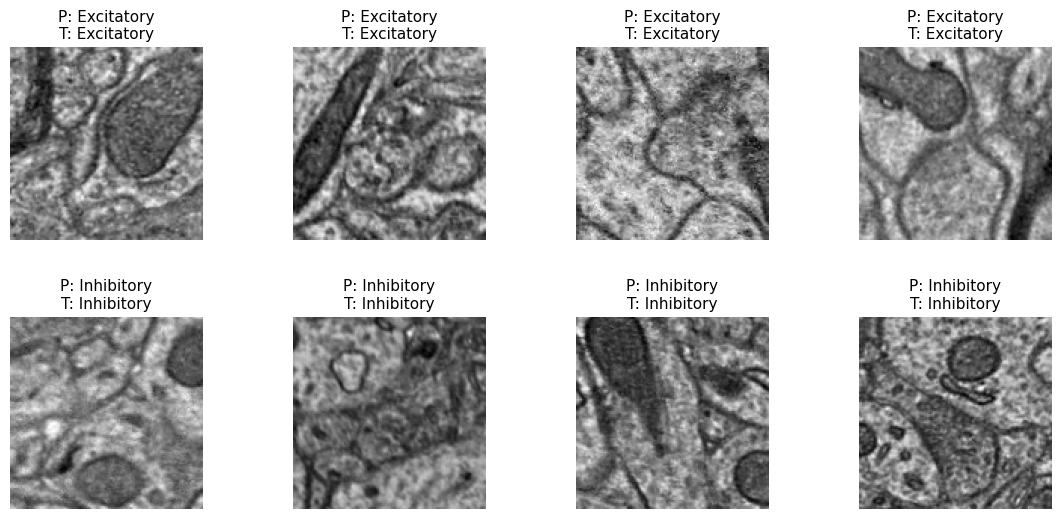

In [7]:
import matplotlib.pyplot as plt
import torch

class_names = ["Excitatory", "Inhibitory"]

#  Run model on full test set
all_images = []
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for test_input, test_target in test_loader:

        test_input = test_input.to(device)
        test_target = test_target.to(device)

        pred = model(test_input)
        _, predicted = torch.max(pred, 1)

        all_images.append(test_input.cpu())
        all_preds.append(predicted.cpu())
        all_labels.append(test_target.cpu())

# Flatten
all_images = torch.cat(all_images, dim=0)
all_preds = torch.cat(all_preds, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# -------------------------------------
# Select CORRECT predictions
# -------------------------------------

correct_mask = (all_preds == all_labels)

# True Excitatory (0) AND correctly predicted
exc_correct_idx = ((all_labels == 0) & correct_mask).nonzero(as_tuple=True)[0]

# True Inhibitory (1) AND correctly predicted
inh_correct_idx = ((all_labels == 1) & correct_mask).nonzero(as_tuple=True)[0]

# Take first 4 correct examples from each class
exc_indices = exc_correct_idx[:4]
inh_indices = inh_correct_idx[:4]

selected_indices = torch.cat([exc_indices, inh_indices], dim=0)

# -------------------------------------
# Denormalization params
# -------------------------------------
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

# -------------------------------------
# Plot 8 Predicted vs. True images, 
# 4 Excitatory, 4 Inhibitory
# -------------------------------------
plt.figure(figsize=(14, 6))

for i, idx in enumerate(selected_indices):
    img = all_images[idx]
    pred_label = class_names[all_preds[idx]]
    true_label = class_names[all_labels[idx]]

    img = img * std + mean
    img = torch.clamp(img, 0, 1)

    plt.subplot(2, 4, i+1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=11)
    plt.axis("off")

plt.subplots_adjust(hspace=0.4)
plt.show()


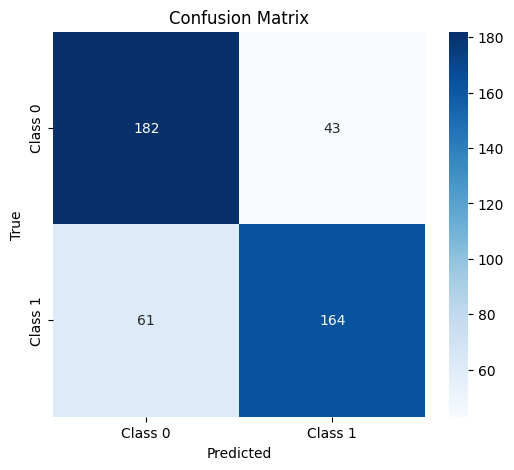


Accuracy:  0.7689
Precision: 0.7706
Recall:    0.7689
F1-Score:  0.7685

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       225
           1       0.79      0.73      0.76       225

    accuracy                           0.77       450
   macro avg       0.77      0.77      0.77       450
weighted avg       0.77      0.77      0.77       450



In [8]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Collect all predictions and targets
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for test_input, test_target in test_loader:
        test_input, test_target = test_input.to(device), test_target.to(device)

        outputs = model(test_input)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(test_target.cpu().numpy())

# Convert to NumPy
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)

# Visual Plot of Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Class 0', 'Class 1'],
    yticklabels=['Class 0', 'Class 1']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print metrics
acc = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

print(f"\nAccuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, zero_division=0))
